In [10]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

module_path = '/home/sbose/time-series-forecasting-federation'
sys.path.insert(0,module_path)
from files_for_appfl.comstock_dataloader import get_comstock
from files_for_appfl.loss import MSELoss
from files_for_appfl.metric import mape
from models.LSTM.LSTMAR import LSTMAR
from models.DARNN.DARNN import DARNN
from models.TRANSFORMER.Transformer import Transformer

# zero weight init
def zero_weights(model):
    for param in model.parameters():
        param.data.zero_()
        
# configure model and other stuff
lookahead, lookback = 4, 12
dtype = torch.float32
device = 'cuda'
num_clients = 12
test_every = 100
xformer_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'd_model' : 128,
    'e_layers' : 4,
    'd_layers' : 4,
    'dtype' : dtype
}
lstm_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'dtype' : dtype
}

# function to zero the weights for initialization
def zero_weights(model):
    for param in model.parameters():
        param.data.zero_()

In [11]:
def train_and_test(
    model_name, # pass as the name containe in a string
    model_kwargs,
    optim_name, # pass as the name containe in a string
    optim_kwargs,
    custom_str,
    normalize = 'True',
    display_time_idx = 500,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    seed = 42,
    BS = 32,
    steps = 1000
):
    
    # master function to train on data and produce output on test set 
    model = nn.DataParallel(eval(model_name)(**model_kwargs))
    model = model.to(device)
    
    optim = eval(optim_name)(model.parameters(), **optim_kwargs)
    loss_fn = MSELoss()
    
    elapsed = 0
    loss_record, mape_record = [], []
    
    # get and combine datasets
    train_set, test_set = [], []
    for bidx in range(num_clients):
        train, test = get_comstock(
            bldg_idx = bidx,
            lookback = lookback,
            lookahead = lookahead,
            dtype = dtype,
            normalize = normalize
        )
        train_set.append(train)
        test_set.append(test)
    train_set, test_set = ConcatDataset(train_set), ConcatDataset(test_set)
    torch.manual_seed(seed)
    train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=8096, shuffle=True)
    
    zero_weights(model)
    loss_record, mape_record = [], []
    for inp, lab in (t:=tqdm(itertools.cycle(train_loader))):
    
        inp, lab = inp.to(device), lab.to(device)
        pred = model(inp)
        loss = loss_fn(lab,pred)
        optim.zero_grad
        loss.backward()
        optim.step()
        # scheduler.step()    
        loss_record.append(loss.item())
        elapsed += 1
        
        t.set_description(f"On experiment {custom_str}, step {elapsed}, loss is {loss.item()}.")
        
        if elapsed % test_every == 0:
            mapes = []
            for inp,lab in test_loader:
                inp = inp.to(device)
                with torch.no_grad():
                    pred = model(inp)
                mapes.append(mape(lab.to('cpu').numpy(),pred.to('cpu').numpy()))
            metric = np.mean(np.array(mapes))
            mape_record.append(metric)
            print(f"On step {elapsed}, MAPE error is {metric} percent.")
            
        if elapsed == steps:
            break
        
    # plot losses
    loss_record = np.array(loss_record)
    plt.plot(np.arange(1,loss_record.size+1),np.array(loss_record))
    plt.xlabel('Steps')
    plt.ylabel('MSE Loss')
    plt.title(f'Losses: {custom_str}')
    plt.ylim(0,np.percentile(loss_record,75))
    plt.show()
    # plot MAPEs
    mape_record = np.array(mape_record)
    plt.plot(np.arange(1,mape_record.size+1),np.array(mape_record))
    plt.xlabel(f'Steps x{test_every}')
    plt.ylabel(f'MAPE')
    plt.title(f'{custom_str}, test set MAPE.')
    plt.show()
    # plot the test sets
    inputs, outputs = [], []
    for idx in range(display_time_idx):
        itm = test_set.__getitem__(idx)
        inputs.append(itm[0])
        outputs.append(itm[1].numpy())
    batched_input = torch.stack(inputs).to(dtype).to(device)
    with torch.no_grad():   
        batched_output = model(batched_input).to('cpu').numpy()
    preds = list(batched_output)
    plot_gt, plot_pred = [], []
    for idx in range(display_time_idx):
        minval, maxval = outputs[idx][-1,1], outputs[idx][-1,2]
        plot_gt.append((outputs[idx][-1,0]-minval)/(maxval-minval))
        plot_pred.append(preds[idx][-1,0])
    plot_gt, plot_pred = np.array(plot_gt), np.array(plot_pred)
    plt.plot(np.arange(1,plot_gt.size+1),plot_gt,label='ground truth')
    plt.plot(np.arange(1,plot_pred.size+1),plot_pred,label='prediction')
    plt.xlabel('Time index')
    plt.ylabel('kWh')
    plt.legend()
    plt.title(f'{custom_str}: performance on test set')

On experiment SGD LSTM Normalized, step 108, loss is 0.005020339973270893.:   1%|       | 106/10508 [00:17<1:45:31,  1.64it/s]

On step 100, MAPE error is 63.02474249492992 percent.


On experiment SGD LSTM Normalized, step 209, loss is 0.022549685090780258.:   2%|▏      | 205/10508 [00:33<1:47:53,  1.59it/s]

On step 200, MAPE error is 174.54215071418068 percent.


On experiment SGD LSTM Normalized, step 308, loss is 0.020568620413541794.:   3%|▏      | 305/10508 [00:49<1:43:06,  1.65it/s]

On step 300, MAPE error is 112.8721757368608 percent.


On experiment SGD LSTM Normalized, step 409, loss is 0.038903433829545975.:   4%|▎      | 405/10508 [01:05<1:41:18,  1.66it/s]

On step 400, MAPE error is 59.748727625066586 percent.


On experiment SGD LSTM Normalized, step 509, loss is 0.011820157989859581.:   5%|▎      | 505/10508 [01:21<1:40:51,  1.65it/s]

On step 500, MAPE error is 53.6120208826932 percent.


On experiment SGD LSTM Normalized, step 609, loss is 0.011347150430083275.:   6%|▍      | 605/10508 [01:37<1:38:34,  1.67it/s]

On step 600, MAPE error is 130.88916865262118 percent.


On experiment SGD LSTM Normalized, step 709, loss is 0.013124436140060425.:   7%|▍      | 705/10508 [01:53<1:38:12,  1.66it/s]

On step 700, MAPE error is 157.49691833149302 percent.


On experiment SGD LSTM Normalized, step 809, loss is 0.006647495552897453.:   8%|▌      | 805/10508 [02:09<1:37:23,  1.66it/s]

On step 800, MAPE error is 53.491879593242295 percent.


On experiment SGD LSTM Normalized, step 909, loss is 0.013930177316069603.:   9%|▌      | 905/10508 [02:25<1:35:33,  1.67it/s]

On step 900, MAPE error is 72.59374856948853 percent.


On experiment SGD LSTM Normalized, step 1000, loss is 0.008472145535051823.:  10%|▊       | 999/10508 [02:41<25:35,  6.19it/s]

On step 1000, MAPE error is 80.22795536301352 percent.


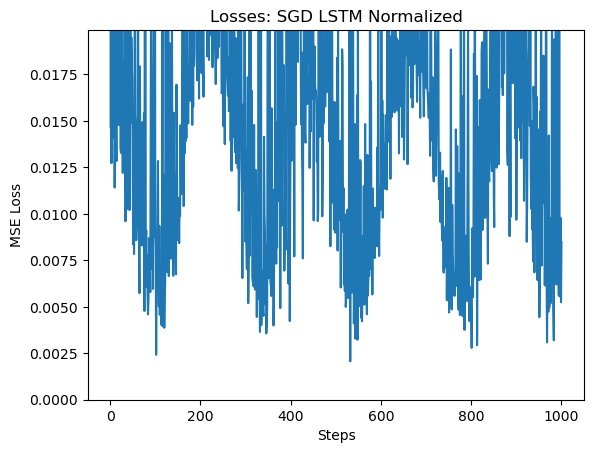

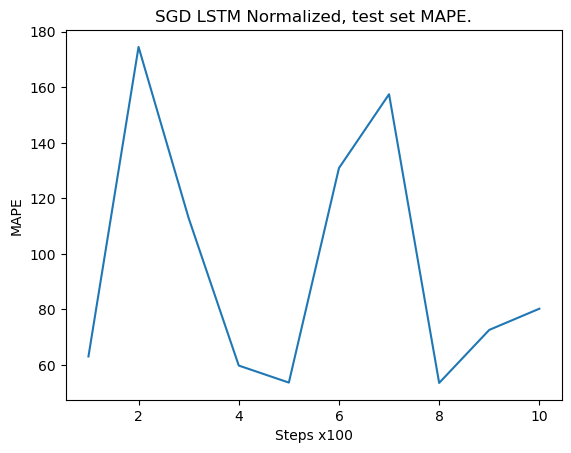

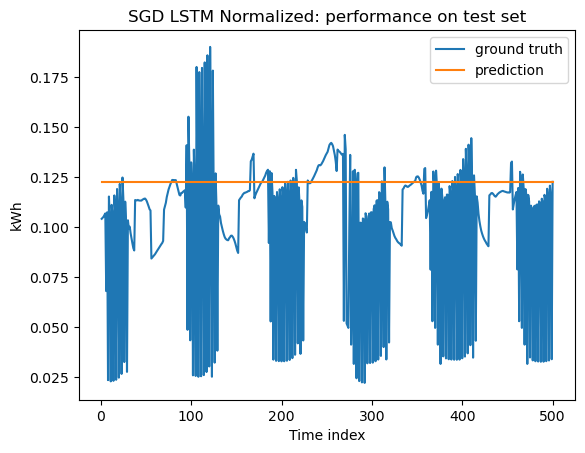

In [3]:
train_and_test(
    'LSTMAR', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 1e-4},
    'SGD LSTM Normalized',
    True,
)

On experiment SGD Transformer Normalized, step 103, loss is 0.015100661665201187.: : 102it [00:20,  1.56s/it]

On step 100, MAPE error is 58.88652042909102 percent.


On experiment SGD Transformer Normalized, step 203, loss is 0.012875387445092201.: : 202it [00:40,  1.54s/it] 

On step 200, MAPE error is 56.07147433541038 percent.


On experiment SGD Transformer Normalized, step 303, loss is 0.006318108178675175.: : 302it [01:00,  1.55s/it] 

On step 300, MAPE error is 102.04915350133723 percent.


On experiment SGD Transformer Normalized, step 403, loss is 0.017847824841737747.: : 402it [01:21,  1.58s/it] 

On step 400, MAPE error is 157.46446631171486 percent.


On experiment SGD Transformer Normalized, step 503, loss is 0.01692667417228222.: : 502it [01:41,  1.55s/it] 

On step 500, MAPE error is 179.46245020086116 percent.


On experiment SGD Transformer Normalized, step 603, loss is 0.018456965684890747.: : 602it [02:01,  1.57s/it]

On step 600, MAPE error is 153.89432907104492 percent.


On experiment SGD Transformer Normalized, step 703, loss is 0.006552745122462511.: : 702it [02:22,  1.58s/it]

On step 700, MAPE error is 96.54091054742986 percent.


On experiment SGD Transformer Normalized, step 803, loss is 0.008970687165856361.: : 802it [02:42,  1.56s/it] 

On step 800, MAPE error is 53.7205696105957 percent.


On experiment SGD Transformer Normalized, step 903, loss is 0.0261467844247818.: : 902it [03:02,  1.57s/it]   

On step 900, MAPE error is 63.33563978021795 percent.


On experiment SGD Transformer Normalized, step 1000, loss is 0.019676538184285164.: : 999it [03:22,  4.93it/s]

On step 1000, MAPE error is 79.91706783121282 percent.


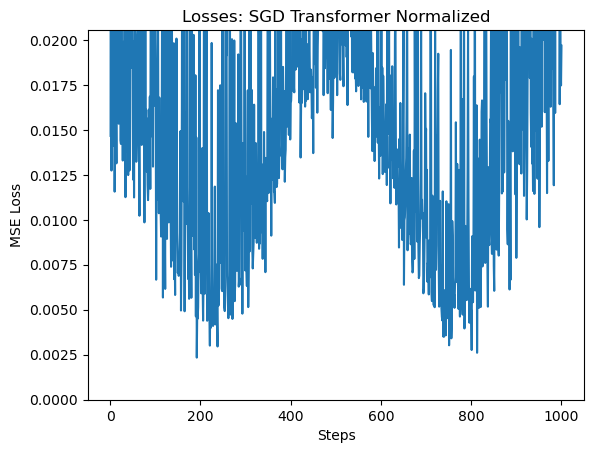

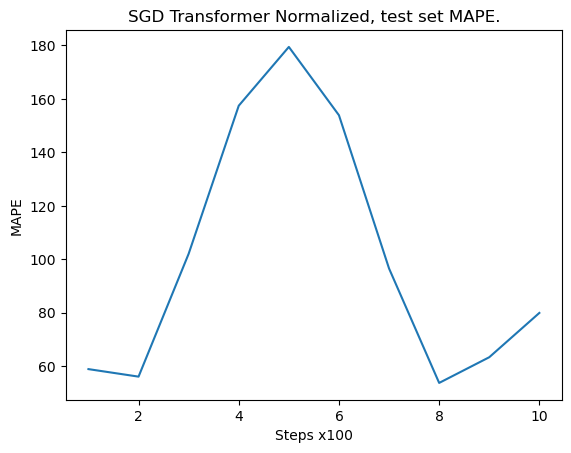

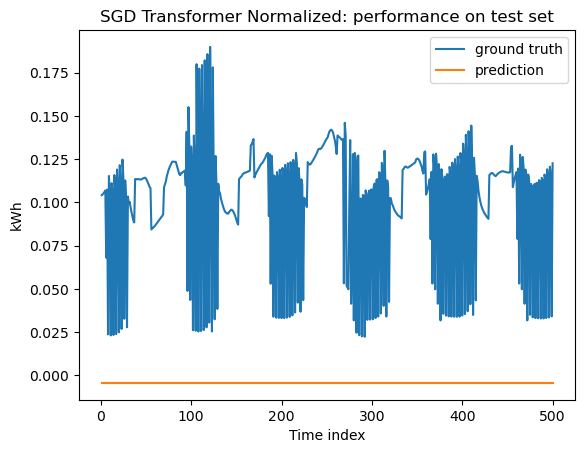

In [12]:
train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 2e-5},
    'SGD Transformer Normalized',
    True,
    steps=1000,
    BS=32
)